In [1]:
import matplotlib as plt

In [2]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.metrics import Recall
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
import keras

In [3]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [4]:
# Объявляем переменные файлов и папки
DIR_TRAIN = "../train/train/"
DIR_TEST = "../test/test/"

PATH_TRAIN = "../train/train.csv"
PATH_TEST = "../test/test.csv"

In [5]:
IMG_SIZE = 256

In [6]:
ds_train, ds_test = image_dataset_from_directory(
    DIR_TRAIN,
    subset="both",
    seed=123,
    labels='inferred',
    label_mode='int',
    image_size=[IMG_SIZE, IMG_SIZE],
    batch_size=16,
    interpolation="bilinear",
    shuffle=True,
    validation_split=0.2,
)

Found 4990 files belonging to 8 classes.
Using 3992 files for training.
Using 998 files for validation.


In [7]:
ds_valid = image_dataset_from_directory(
    DIR_TEST,
    labels='inferred',
    label_mode='int',
    image_size=[IMG_SIZE, IMG_SIZE],
    batch_size=16,
    interpolation="bilinear",
    shuffle=True,
)

Found 2138 files belonging to 8 classes.


In [8]:
from tensorflow.keras.layers import RandomContrast, RandomFlip, RandomRotation
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import ResNet50V2, ResNet152V2
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
# pretrained_base = InceptionV3(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3])
# pretrained_base = ResNet152V2(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3], classes = 8)
pretrained_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=[IMG_SIZE, IMG_SIZE, 3], classes = 8)
pretrained_base.trainable = False

In [10]:
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights = True, verbose = True)

In [11]:
model = keras.Sequential([
    
    layers.Rescaling(1./255),

    layers.InputLayer(input_shape=[IMG_SIZE, IMG_SIZE, 3]),
    
    # Data Augmentation
    RandomContrast(factor=0.10),
    RandomFlip(mode='horizontal'),
    RandomRotation(factor=0.10),

    pretrained_base,

    # Head
    # layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    # layers.Dropout(0.5),
    layers.Dense(8, activation='softmax'),
])

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss = 'SparseCategoricalCrossentropy',
    metrics = ['SparseCategoricalAccuracy']
)

In [13]:
# 1.0    0.317836
# 3.0    0.194188
# 4.0    0.159719
# 5.0    0.103006
# 0.0    0.064329
# 2.0    0.063327
# 6.0    0.058717
# 7.0    0.038878

# 1.0    0.682164
# 3.0    0.805812
# 4.0    0.840281
# 5.0    0.896994
# 0.0    0.935671
# 2.0    0.936673
# 6.0    0.941283
# 7.0    0.961122

class_weight = {
    0: 0.064329,
    1: 0.317836,
    2: 0.063327,
    3: 0.194188,
    4: 0.159719,
    5: 0.103006,
    6: 0.058717,
    7: 0.038878
}

In [14]:
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=10, 
    callbacks=[callback],
    class_weight = class_weight
)

Epoch 1/10
250/250 [==============================] - 53s 180ms/step - loss: 0.1279 - sparse_categorical_accuracy: 0.7573 - val_loss: 0.5987 - val_sparse_categorical_accuracy: 0.8487
Epoch 2/10
250/250 [==============================] - 43s 173ms/step - loss: 0.0577 - sparse_categorical_accuracy: 0.8131 - val_loss: 0.6300 - val_sparse_categorical_accuracy: 0.8567
Epoch 3/10
250/250 [==============================] - 43s 174ms/step - loss: 0.0450 - sparse_categorical_accuracy: 0.8297 - val_loss: 0.8029 - val_sparse_categorical_accuracy: 0.8427
Epoch 4/10
250/250 [==============================] - 44s 175ms/step - loss: 0.0502 - sparse_categorical_accuracy: 0.8302 - val_loss: 0.5314 - val_sparse_categorical_accuracy: 0.8587
Epoch 5/10
250/250 [==============================] - 44s 177ms/step - loss: 0.0418 - sparse_categorical_accuracy: 0.8505 - val_loss: 0.6047 - val_sparse_categorical_accuracy: 0.8457
Epoch 6/10
250/250 [==============================] - 45s 179ms/step - loss: 0.0472 -

<AxesSubplot:>

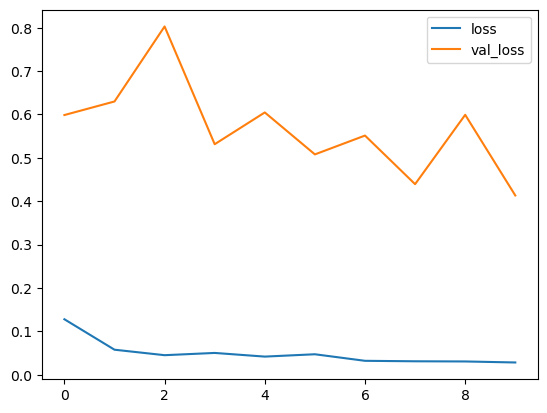

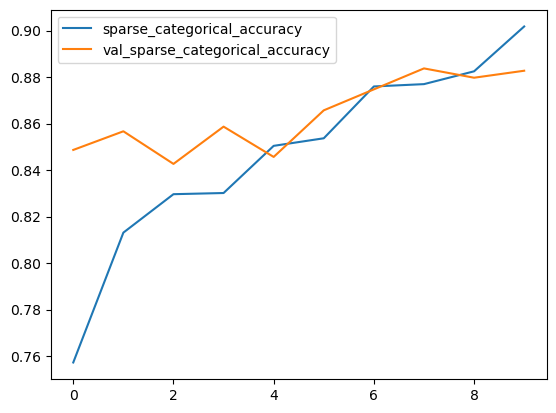

In [15]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy']].plot()

In [25]:
### Добавить деление на 255 !!!
print(model.evaluate(ds_test, use_multiprocessing = True))

63/63 [==============================] - 3s 47ms/step - loss: 0.4132 - sparse_categorical_accuracy: 0.8828
[0.4132463037967682, 0.882765531539917]


In [26]:
import numpy as np
preds_softmax = model.predict(ds_test, use_multiprocessing=True)
preds = np.argmax(preds_softmax, axis = 1)

63/63 [==============================] - 3s 44ms/step


In [43]:
targets = []
for batch, target in ds_test:

    targets.extend(target.numpy())

In [27]:
from sklearn.metrics import recall_score

In [45]:
val_accuracy = recall_score(targets, preds, average = "macro")
print(f"Validation accuracy = {val_accuracy}")

Validation accuracy = 0.7783411231441094
